In [1]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
# import tensorflow_io as tfio
from tensorflow.python.client import device_lib
from tensorflow.python.ops.numpy_ops import np_config
        

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
img_w = 256
img_h = 256
latent_shape = (8,8,512)

In [ ]:
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(img_w, img_h, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
_vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False)

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# setting the retraining off
for layer in _vgg16.layers:
    layer.trainable = False

In [ ]:
class FeatureExtractor:
    '''
    Description : Class to Extract the Features from the given images
    '''
    @staticmethod
    def getLatentSpaceFromVGG(_l, _ab):
        gray_img = gray2rgb(_l)
        print(gray_img.shape)
        gray_img = gray_img.reshape((1,) + gray_img.shape)
        print('After adding 1 dim shape :', gray_img.shape)
        latentSpace = vgg16.predict(gray_img)
        print(latentSpace)
        print(latentSpace.shape)
        latentSpace = latentSpace.reshape(latent_shape)
        return latentSpace, _ab

    # to fix the shape
    @staticmethod
    def fixup_shape(_latentSpace, _ab, w, h):

        '''
        Description : 
                Method to fix the shape of L and AB channels i.e X and Y
        Input :
                _latentSpace => Extracted Feature Latent Space 
                _ab => AB channel
                w => Width of the Image 
                h => Height of the Image
        Returns :
                tf.Tensor (shape => (_lw, _lh, _lc)), tf.Tensor (shape => (w, h, 2))
        '''
        _lw, _lh, _lc = latent_shape
        _latentSpace.set_shape([_lw, _lh, _lc])
        _ab.set_shape([w, h, 2])
        return _latentSpace, _ab

In [ ]:
class DatasetLoader:
    '''
    Description : Class to load the Dataset
    '''

    # Method to load the dataset from the dir
    @staticmethod
    def loadDataSetFromDir(imageDataPath, isShuffle = False):
        '''
        Description : 
                Method to load the dataset from the directory
        Input :
                imageDataPath => Path to the directory where the images are located (dType - String)
                isShuffle => If the images in the dataset to be shuffled (Default - False)
        Returns :
                TensorSliceDataset 
        '''
        return tf.data.Dataset.list_files(imageDataPath, shuffle=isShuffle)
    
    # Method to load the dataset from the numpy.array
    @staticmethod
    def loadDataSetFromNumpy(numpyArr):
        '''
        Description : 
                Method to load the dataset from the numpy
        Input :
                numpyArr => numpy.array containing the data 
        Returns :
                TensorSliceDataset 
        '''
        return tf.data.Dataset.from_tensor_slices(numpyArr)

#### ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB

In [ ]:
class ImageUtils:

    '''
    Description : ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB
    '''

    # Method to get the RGB images
    @staticmethod
    def getRGBData(filePath, img_width, img_height):
        '''
        Description : 
                Method to get the RGB image from the given path
        Input :
                filePath => File path to the image (dType - String)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor 
        '''
        filePath = filePath.numpy().decode('utf-8')
        image = imread(filePath)
        image = resize(image, output_shape=[img_width, img_height])         
        # resize method gives resized image along with normalization
        return image

    # Method to get the LAB images
    @staticmethod
    def getLABData(image):
        '''
        Description : 
                Method to get the LAB image from the given image
        Input :
                image => RGB Image 
        Returns :
                tf.Tensor 
        '''
        labImage = rgb2lab(image)
        return labImage


    # # Method to get the training data
    # def getTrainingData(filePath):

    #     image = tf.io.read_file(filePath)
    #     image = tf.io.decode_jpeg(image)
    #     image = tf.image.convert_image_dtype(image, tf.float32)

    #     labImage = tfio.experimental.color.rgb_to_lab(image)

    #     return tf.reshape(labImage[:,:,0], shape=[256,256,1]), labImage[:,:,1:]


    # Method to get the X(L) and Y(AB) data
    @staticmethod
    def getXYData(labImage, img_width, img_height):
        '''
        Description : 
                Method to split LAB image into L and AB channels as X and Y
        Input :
                labImage => LAB Image
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor, tf.Tensor 
        '''
        _l = tf.reshape(labImage[:,:,0], shape=[img_width,img_height,1])
        _ab = tf.reshape(labImage[:,:,1:] / 128, shape=[img_width,img_height,2])
        return _l, _ab

    # to fix the shape
    @staticmethod
    def fixup_shape(_l, _ab, w, h):

        '''
        Description : 
                Method to fix the shape of L and AB channels i.e X and Y
        Input :
                _l => L channel
                _ab => AB channel
                w => Width of the Image 
                h => Height of the Image
        Returns :
                tf.Tensor (shape => (w,h,1)), tf.Tensor (shape => (w,h,2))
        '''

        _l.set_shape([w, h, 1])
        _ab.set_shape([w, h, 2])
        return _l, _ab

#### Mapper class to Map the given Dataset

In [ ]:
class DatasetMapper:

    '''
    Description : Mapper class to map the given dataset
    '''

    # Method to get the only RGB image Dataset from the give Image File Name Dataset
    @staticmethod
    def getRGBDataset(imgFileNames_ds, img_width, img_height):
        '''
        Description : 
                Method to get the only RGB image Dataset from the give Image File Name Dataset
        Input :
                imgFileNames_ds => TensorSliceDataset (consist of the image file names)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset Shapes: (img_width, img_height, None), types: tf.float32
        '''
        return imgFileNames_ds.map(lambda x : tf.py_function(ImageUtils.getRGBData, 
                                                             [x, img_width, img_height], 
                                                             tf.float32))

    # Method to get the only LAB images from the RGB image dataset
    @staticmethod
    def getLABDataset(rgbImg_ds):
        '''
        Description : 
                Method to get the only LAB images from the RGB image dataset
        Input :
                rgbImg_ds => MapDatset (consist of the RGB images)
            
        Returns :
                MapDataset Shapes: (rgbImg_width, rgbImg_height, None), types: tf.float32
        '''
        return rgbImg_ds.map(lambda x : tf.py_function(ImageUtils.getLABData,
                                                       [x],
                                                       tf.float32))

    # Method to split the LAB Image into L(X) and AB(Y) channels
    @staticmethod
    def getXYDataset(labImg_ds, img_width, img_height):
        '''
        Description : 
                Method to split the LAB Image into L(X) and AB(Y) channels
        Input :
                labImage => MapDatset (consist of the LAB images)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset shapes: ((img_width, img_height, 1), (img_width, 2img_height56, 2)), types: (tf.float32, tf.float32)
        '''

        ds = labImg_ds.map(lambda x : tf.py_function(ImageUtils.getXYData,
                                                       [x, img_width, img_height],
                                                       [tf.float32, tf.float32]))

        return ds.map(lambda x, y : ImageUtils.fixup_shape(x, y, img_width, img_height))

In [ ]:
image_ds = DatasetLoader.loadDataSetFromDir('/content/*.jpg')

In [ ]:
len(image_ds)

2

In [ ]:
img = imread('/content/test3.jpg')

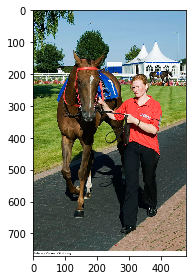

In [ ]:
imshow(img)

In [ ]:
img.shape

(771, 480, 3)

In [ ]:
img_resize = resize(img, output_shape=(256,256))

In [ ]:
img_resize.shape

(256, 256, 3)

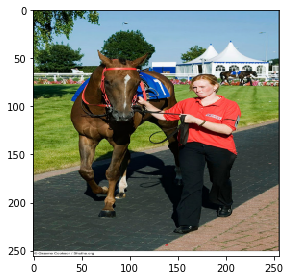

In [ ]:
imshow(img_resize)

In [ ]:
gray = rgb2gray(img_resize)

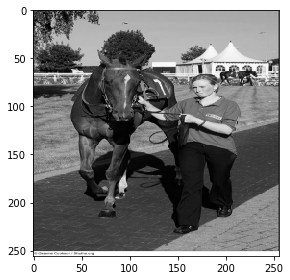

In [ ]:
imshow(gray)

In [ ]:
gray.shape

(256, 256)

In [ ]:
gray_r = gray2rgb(gray)

In [ ]:
gray_r.shape

(256, 256, 3)

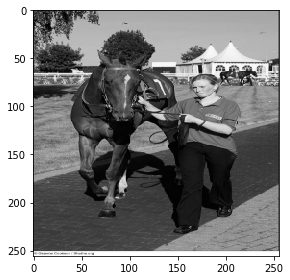

In [ ]:
imshow(gray_r)

In [ ]:
_latent, _ab = FeatureExtractor.getLatentSpaceFromVGG(gray, False)

(256, 256, 3)
After adding 1 dim shape : (1, 256, 256, 3)
[[[[0.00000000e+00 0.00000000e+00 1.56349540e-01 ... 0.00000000e+00
    1.17328143e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 8.19501579e-02 ... 0.00000000e+00
    1.02792275e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.21657068e-01 ... 0.00000000e+00
    5.97838640e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    3.45030397e-01 0.00000000e+00]
   [3.19560915e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.73595130e-01 0.00000000e+00]
   [3.96882951e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.48514628e-02 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.88402843e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.65621603e-01 ... 0.00000000e+00
    8.59318137e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 8.69143486e-01 ... 0.00000000e+00
    2.34772384e-01 1.35975629e-01]
   ...

In [3]:
test = imread('/content/test3.jpg')

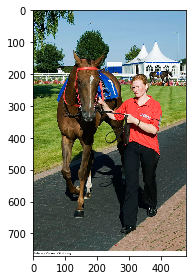

In [4]:
imshow(test)

In [6]:
test = resize(test, output_shape=[256,256])

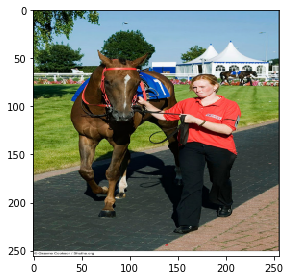

In [10]:
imshow(test)

In [11]:
lab = rgb2lab(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


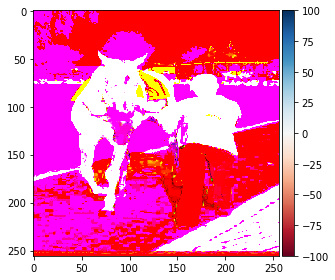

In [12]:
imshow(lab)

In [14]:
l = lab[:,:,0]

In [15]:
l.shape

(256, 256)

In [16]:
gray_l = gray2rgb(l)

In [17]:
gray_l.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


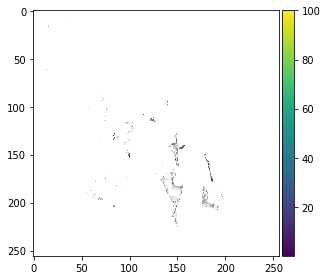

In [18]:
imshow(gray_l)